In [21]:
'''
Create a table for the records of full morphology reconstruction
'''

'\nCreate a table for the records of full morphology reconstruction\n'

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from utilities import *
import pickle
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, Birch
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import igraph
from math import ceil
from timeit import default_timer as timer

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def change_name(df, old_name, new_name, axis="columns"):
    if(axis=="columns"):
        if(old_name in df.columns.tolist()):
            print(old_name, "\t-->\t", new_name)
            df = df.rename({old_name:new_name}, axis=axis)
        return df
    if(axis=="index"):
        if(old_name in df.index.tolist()):
            df = df.rename({old_name:new_name}, axis=axis)
            print(old_name, "\t-->\t", new_name)
        return df
    print("Axis needs to be either columns or index!")
    return df
        
def simple_name(df):
    df = change_name(df, "Percentage_lost(%)", "Unconnected(%)")
    df = change_name(df, "Number_single_trees", "N_Single_Trees")
    df = change_name(df, "Number of Nodes", "N_Nodes")
    df = change_name(df, "Number of Tips", "N_Tips")
    df = change_name(df, "Number of Branches", "N_Branches")
    df = change_name(df, "Number of Bifurcatons", "N_Bifurcations")
    df = change_name(df, "Number of Bifurcations", "N_Bifurcations")
    df = change_name(df, "Number of Stems", "N_Stems")
    df = change_name(df, "Overall Width", "Width")
    df = change_name(df, "Overall Depth", "Depth")
    df = change_name(df, "Overall Height", "Height")
    df = change_name(df, "Total Length", "Total_Length")
    df = change_name(df, "Max Euclidean Distance", "Max_E_Distance")
    df = change_name(df, "Max Path Distance", "Max_P_Distance")
    df = change_name(df, "Max Branch Order", "Max_Order")
    df = change_name(df, "Average Fragmentation", "Fragmentation")
    df = change_name(df, "Average Contraction", "Contraction")
    df = change_name(df, "Average Bifurcation Angle Local", "Angle_Local")
    df = change_name(df, "Average Bifurcation Angle Remote", "Angle_Remote")
    df = change_name(df, "Hausdorff Dimension", "Hausdorff_Dim")
    return df
  
# def feature_hist_compare(df_list, df_names, ncol=4, len_single_plot = 5):
#     n = df_list[0].shape[1]
#     featuer_names = df_list[0].columns.tolist()
#     assert all([df.shape[1]==n for df in df_list])
#     assert len(df_list) == len(df_names)
#     if((n % ncol)==0):
#         nrow = int(n / ncol)
#     else:
#         nrow = int(n / ncol + 1)
        
#     print(nrow, ncol)
#     fig, ax = plt.subplots(nrow, ncol, figsize=(len_single_plot*ncol, len_single_plot*nrow))
#     ax = ax.reshape(-1,)
#     for i in range(n):
#         ax[i].set_title(featuer_names[i])
#         for j in range(len(df_list)):
#             df = df_list[j]
#             ax[i].hist(df.iloc[:,i], histtype='step', normed=True, label=df_names[j])
#         ax[i].legend()
#     return

In [24]:
def sub_df(df, feature_type):
    lab = []
    for feature in df.columns.tolist():
        feature = str(feature)
        if feature.find(feature_type)==0:
            lab.append(feature)
    return df[lab]

def loading_plot(loadings, ax, pc=[0,1], labels=None):
    if len(loadings)==0:
        return
    feature_names = loadings.index.tolist()
    for i in range(loadings.shape[0]):
        ax.arrow(0, 0, loadings.iloc[i,pc[0]], loadings.iloc[i,pc[1]],color = 'r',alpha = 0.5)
        ax.text(loadings.iloc[i,pc[0]]* 1.15, loadings.iloc[i,pc[1]] * 1.15, feature_names[i], color = 'g', ha = 'center', va = 'center')
    ax.set_xlim(np.min(loadings.iloc[:,pc[0]])*1.3,np.max(loadings.iloc[:,pc[0]])*1.3)
    ax.set_ylim(np.min(loadings.iloc[:,pc[1]])*1.3,np.max(loadings.iloc[:,pc[1]])*1.3)
    ax.set_xlabel("PC{}".format(pc[0]+1))
    ax.set_ylabel("PC{}".format(pc[1]+1))    
    ax.grid()
    return
   
def scatter_plot(X_plot, ax, pc=[0,1]):
    ax.scatter(X_plot[:, pc[0]], X_plot[:, pc[1]], c='w')
    for ct in u_celltypes:
        lab = (celltypes['Type']==ct)
        ax.scatter(X_plot[lab, pc[0]], X_plot[lab, pc[1]], c=celltypes_lut[ct], label=ct)
    ax.legend()
    ax.set_xlabel("PC{}".format(pc[0]+1))
    ax.set_ylabel("PC{}".format(pc[1]+1))    
    return


In [25]:
def load_qc(brain_list, celltype_list):
    combined = None
    for brain in brain_list:
        for celltype in celltype_list:
            qc = load_features_as_one(['data/QC/'+brain+'_'+celltype+'.QC.txt'])
            qc = simple_name(qc)
            for i in range(len(qc)):
                qc = qc.rename({qc.index[i]:(brain+'_'+qc.index[i])}, axis='index')
            qc['Brain'] = brain
            if combined is None:
                combined = qc
            else:
                combined = pd.concat([combined, qc], axis=0)
    combined['Type'] = pd.Categorical(combined['Type'])   
    combined['Brain'] = pd.Categorical(combined['Brain'])   
    return combined

def load_dendrite(brain_list, celltype_list):
    combined = None
    for brain in brain_list:
        for celltype in celltype_list:
            ddt = load_features_as_one(['data/features/'+brain+'_'+celltype+'.dendrite.features'], 
                                       drop_attr=["Soma Surface", "Average Diameter", "Total Surface", 
                                                  "Total Volume", "Average Parent-daughter Ratio"])
            ddt = ddt.drop(['Type'], axis=1)
            ddt = simple_name(ddt)
            for i in range(ddt.shape[1]):
                ddt = ddt.rename({ddt.columns[i]:('D.'+ddt.columns[i])}, axis='columns')
            for i in range(len(ddt)):
                ddt = ddt.rename({ddt.index[i]:(brain+'_'+ddt.index[i])}, axis='index')
            if combined is None:
                combined = ddt
            else:
                combined = pd.concat([combined, ddt], axis=0)
    return combined

def load_long_axon(brain_list, celltype_list):
    combined = None
    for brain in brain_list:
        for celltype in celltype_list:
            lpa = load_features_as_one(['data/features/'+brain+'_'+celltype+'.long_axon.features'])
            lpa = lpa.loc[:, ['Overall Width', 'Overall Height', 'Overall Depth', 
                              'Max Euclidean Distance', "Max Path Distance"]]
            lpa["Straightness"] = lpa['Max Euclidean Distance'] / lpa['Max Path Distance']
            lpa = simple_name(lpa)
            for i in range(lpa.shape[1]):
                lpa = lpa.rename({lpa.columns[i]:('L.'+lpa.columns[i])}, axis='columns') 
            for i in range(len(lpa)):
                lpa = lpa.rename({lpa.index[i]:(brain+'_'+lpa.index[i])}, axis='rows')
            if combined is None:
                combined = lpa
            else:
                combined = pd.concat([combined, lpa], axis=0)
    return combined

def load_proximal_axon(brain_list, celltype_list):
    combined = None
    for brain in brain_list:
        for celltype in celltype_list:
            df = load_features_as_one(['data/features/'+brain+'_'+celltype+'.proximal_axon.features'], 
                                       drop_attr=["Soma Surface", "Average Diameter", "Total Surface", 
                                                  "Total Volume", "Average Parent-daughter Ratio",
                                                 "Number of Stems", "Number of Nodes"
                                                 ])
            df = df.drop(['Type'], axis=1)
            df = simple_name(df)
            for i in range(df.shape[1]):
                df = df.rename({df.columns[i]:('P.'+df.columns[i])}, axis='columns')
            for i in range(len(df)):
                df = df.rename({df.index[i]:(brain+'_'+df.index[i])}, axis='index')
            if combined is None:
                combined = df
            else:
                combined = pd.concat([combined, df], axis=0)
    return combined

def load_distal_axon(brain_list, celltype_list):
    combined = None
    for brain in brain_list:
        for celltype in celltype_list:
            df = load_features_as_one(['data/features/'+brain+'_'+celltype+'.distal_axon.features'], 
                                       drop_attr=["Soma Surface", "Average Diameter", "Total Surface", 
                                                  "Total Volume", "Average Parent-daughter Ratio",
                                                 "Number of Stems", "Number of Nodes"
                                                 ])
            df = df.drop(['Type'], axis=1)
            df = simple_name(df)
            for i in range(df.shape[1]):
                df = df.rename({df.columns[i]:('T.'+df.columns[i])}, axis='columns')
            for i in range(len(df)):
                df = df.rename({df.index[i]:(brain+'_'+df.index[i])}, axis='index')
            if combined is None:
                combined = df
            else:
                combined = pd.concat([combined, df], axis=0)
    return combined

def create_table(brain_list, celltype_list):
    qc = load_qc(brain_list, celltype_list)
    ddt = load_dendrite(brain_list, celltype_list)
    lpa = load_long_axon(brain_list, celltype_list)
    pxa = load_proximal_axon(brain_list, celltype_list)
    dsa = load_distal_axon(brain_list, celltype_list)
#     df = pd.concat([qc, ddt, lpa, pxa, dsa], axis=1, join="inner")
    df = pd.concat([qc, ddt, lpa, pxa], axis=1, join="inner")
    return df

In [26]:
brain_list = ['17302', 
#               '17545'
             ]
celltype_list = ['CPU', 'LGN', 'Thalamuscells']
tb = create_table(brain_list, celltype_list)

Percentage_lost(%) 	-->	 Unconnected(%)
Number_single_trees 	-->	 N_Single_Trees
Percentage_lost(%) 	-->	 Unconnected(%)
Number_single_trees 	-->	 N_Single_Trees
Percentage_lost(%) 	-->	 Unconnected(%)
Number_single_trees 	-->	 N_Single_Trees
Number of Nodes 	-->	 N_Nodes
Number of Tips 	-->	 N_Tips
Number of Branches 	-->	 N_Branches
Number of Bifurcatons 	-->	 N_Bifurcations
Number of Stems 	-->	 N_Stems
Overall Width 	-->	 Width
Overall Depth 	-->	 Depth
Overall Height 	-->	 Height
Total Length 	-->	 Total_Length
Max Euclidean Distance 	-->	 Max_E_Distance
Max Path Distance 	-->	 Max_P_Distance
Max Branch Order 	-->	 Max_Order
Average Fragmentation 	-->	 Fragmentation
Average Contraction 	-->	 Contraction
Average Bifurcation Angle Local 	-->	 Angle_Local
Average Bifurcation Angle Remote 	-->	 Angle_Remote
Hausdorff Dimension 	-->	 Hausdorff_Dim
Number of Nodes 	-->	 N_Nodes
Number of Tips 	-->	 N_Tips
Number of Branches 	-->	 N_Branches
Number of Bifurcatons 	-->	 N_Bifurcations
Num

In [27]:
tb_sel = tb.iloc[np.array((tb['Unconnected(%)']<10) & 
                          (tb['D.N_Nodes']>1000) &
                          (tb['Type']!='CPU')
                         ), :]
tb_sel = tb_sel.drop(["D.N_Nodes"], axis=1)
print(tb_sel.shape)

# Cell types
celltypes = pd.DataFrame(tb_sel['Type'])
u_celltypes = list(set(celltypes['Type']))

assert len(u_celltypes)<10
celltypes_pal = ['C1', 'C2']
celltypes_lut = dict(zip(sorted(u_celltypes), celltypes_pal))
celltypes_col = []
for tp in celltypes['Type'].tolist():
    celltypes_col.append(celltypes_lut[tp])
    
# Brain ids
brains = pd.DataFrame(tb_sel['Brain'])
u_brains = list(set(brains['Brain']))

assert len(u_brains)<10

brains_pal = ['C'+str(i) for i in range(len(u_brains))]
brains_lut = dict(zip(sorted(u_brains), brains_pal))
brains_col = []
for tp in brains['Brain'].tolist():
    brains_col.append(brains_lut[tp])

(25, 42)


## Analysis

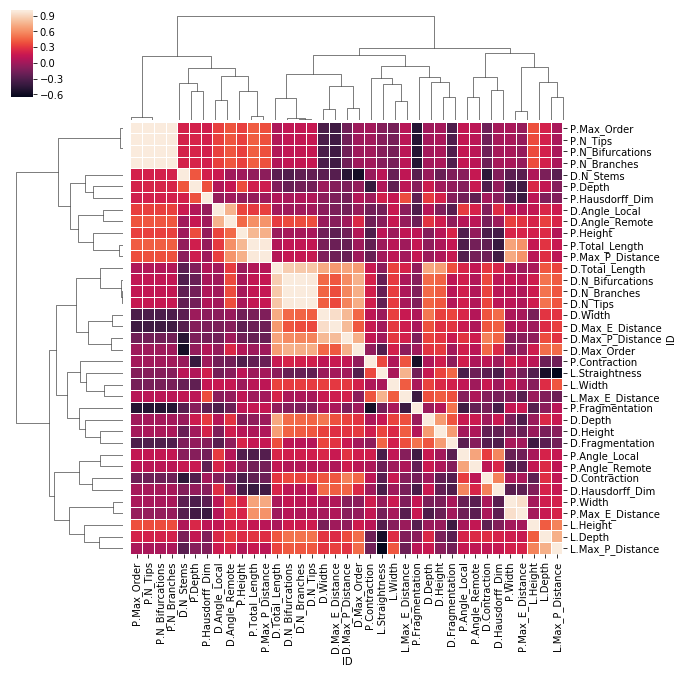

In [28]:
df_orig = tb_sel.iloc[:, 5:]
df = pd.DataFrame(scale(df_orig), columns=df_orig.columns, index=df_orig.index.tolist())
df_score = df.copy()
for col_name in df_score.columns:
    df_score[col_name] = df_score[col_name].rank(pct=True)

Z_feature = linkage(df.transpose(), method='ward', metric='euclidean')
corr_feature = df.corr(method='spearman')
g = sns.clustermap(corr_feature, linewidths=0.01, vmax=1.0, square=True, 
                   col_linkage=Z_feature, row_linkage=Z_feature,
                   linecolor='white', annot=False, figsize=(10,10))
g.savefig("Figure/Cor_Features_AllNeurons_Thalamus_LGN.pdf")

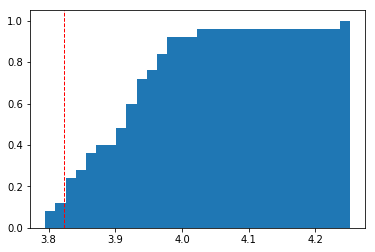

In [29]:
_ = plt.hist(np.log10(tb_sel["L.Max_E_Distance"]), bins=30, cumulative=True, density=True)
thres = np.percentile(np.log10(tb_sel["L.Max_E_Distance"]), 10)
plt.axvline(thres, c='r', lw=1, ls='dashed')
plt.ylim = (0,1.1)

In [30]:
sub_df(tb_sel.loc[tb_sel["L.Max_E_Distance"]<10**thres], "L")

ID,L.Width,L.Height,L.Depth,L.Max_E_Distance,L.Max_P_Distance,L.Straightness
17302_049,8768.49,6896.72,444.385,6305.28,21517.8,0.293026
17302_041,8613.06,6840.24,434.250,6237.82,24530.1,0.254292
17302_025,10305.10,3784.00,2228.690,6626.05,29912.3,0.221516


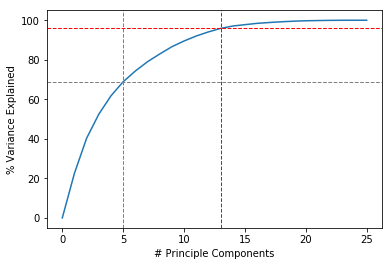

In [31]:
colors = celltypes_col

# Create a regular PCA model 
pca = PCA(n_components=df.shape[1])
# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(df)

tp = np.append(np.array([0]), np.cumsum(pca.explained_variance_ratio_)*100)
for i in range(len(tp)):
    if tp[i]>95:
        use_pcs = i
        break
plt.plot(range(0, len(tp)), tp)
plt.xlabel('# Principle Components')
plt.ylabel('% Variance Explained')
plt.axvline(use_pcs, c='r', lw=1, ls='dashed')
plt.axhline(tp[use_pcs], c='r', lw=1, ls='dashed')
plt.axvline(5, c='grey', lw=1, ls='dashed')
plt.axhline(tp[5], c='grey', lw=1, ls='dashed')
# plt.ylim(tp[1], 102)
# Fit and transform the data to the model
reduced_data_pca = reduced_data_pca[:,:use_pcs]

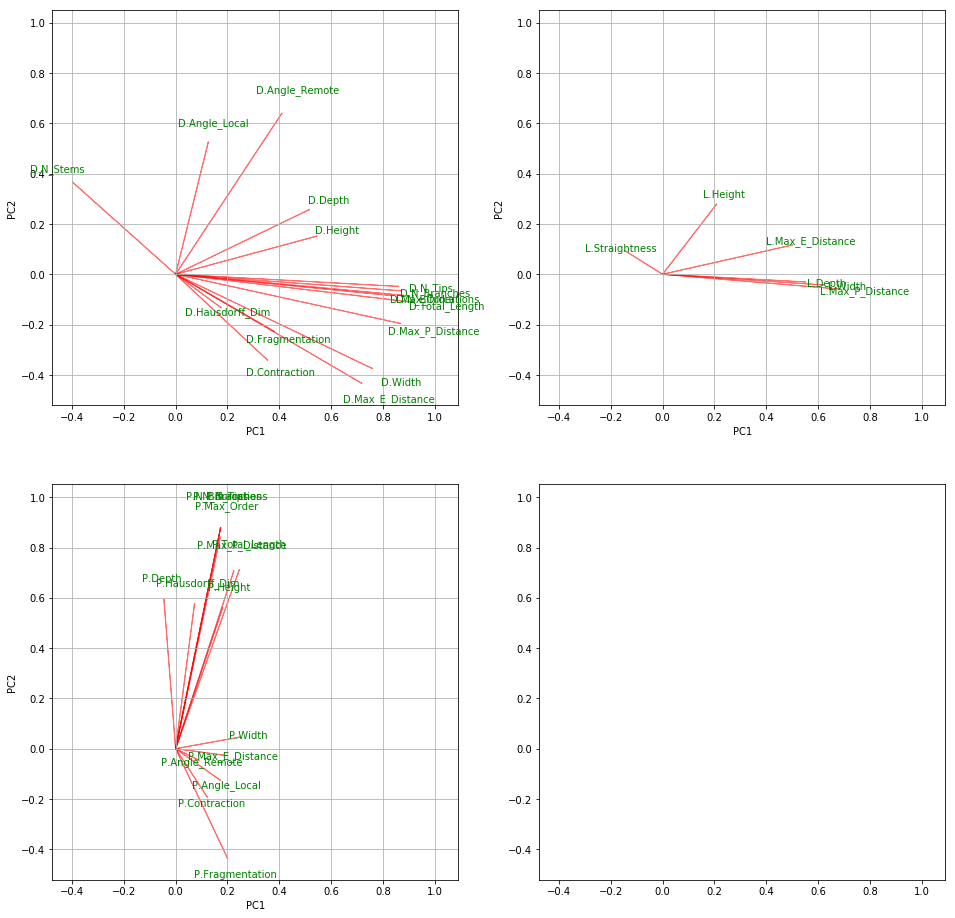

In [32]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pd.DataFrame(loadings[:,:use_pcs], index=df.columns, columns=range(1, use_pcs+1))
xlim = (np.min(loadings[1])*1.2, np.max(loadings[1])*1.2)
ylim = (np.min(loadings[2])*1.2, np.max(loadings[2])*1.2)

fig, ax = plt.subplots(2,2,figsize=(16, 16))
ax = ax.reshape(-1,)
featuer_prefix = ['D', 'L', 'P', 'T']
for i in range(4):
    loading_plot(sub_df(loadings.transpose(), featuer_prefix[i]).transpose(), ax[i])
    ax[i].set_xlim(xlim[0], xlim[1])
    ax[i].set_ylim(ylim[0], ylim[1])
    


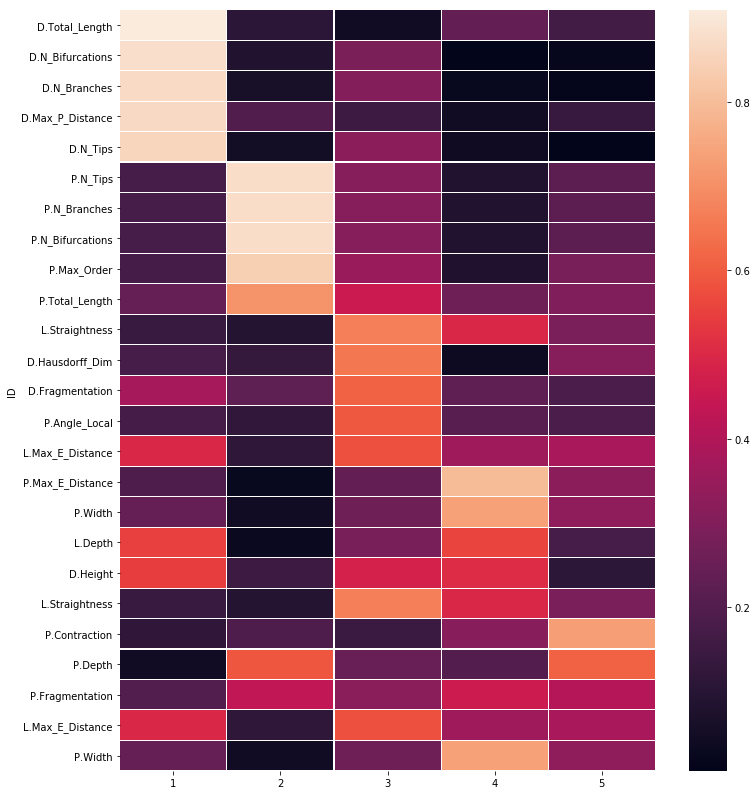

In [33]:
tp = []
loadings_abs = loadings.abs()
for i in range(5):
    tp = tp + loadings.abs().sort_values([i+1], ascending=False).index.tolist()[:5]
    

fig, ax = plt.subplots(1,1,figsize=(12,14))
_ = sns.heatmap(loadings_abs.loc[tp, [1,2,3,4,5]], linewidths=0.1, ax = ax)

fig.savefig("Figure/PCA_Top5_AllNeurons_Thalamus_LGN.pdf")

Text(0,0.5,'distance (Ward)')

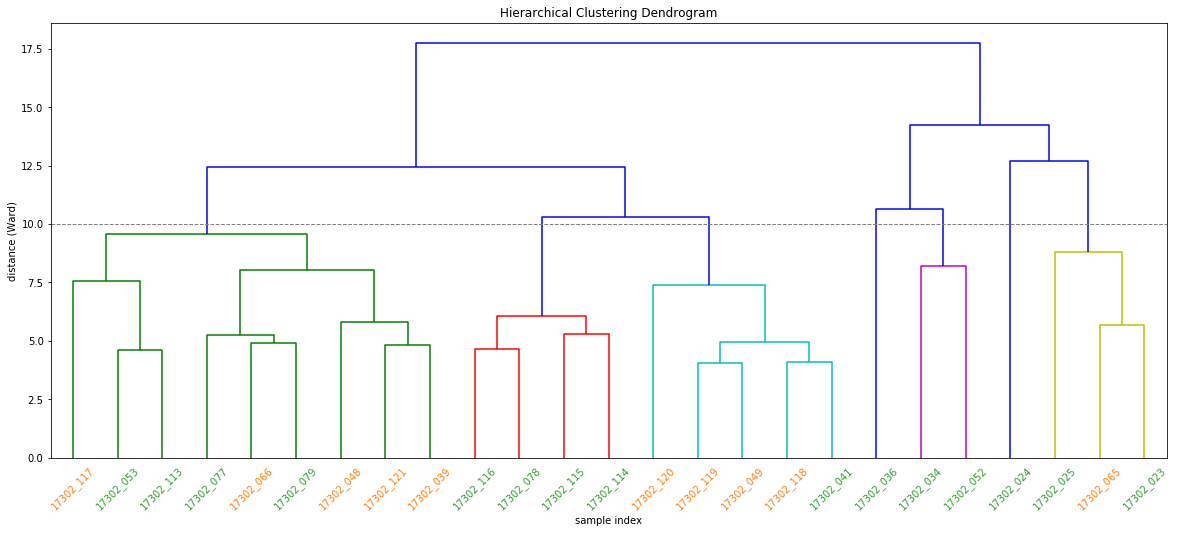

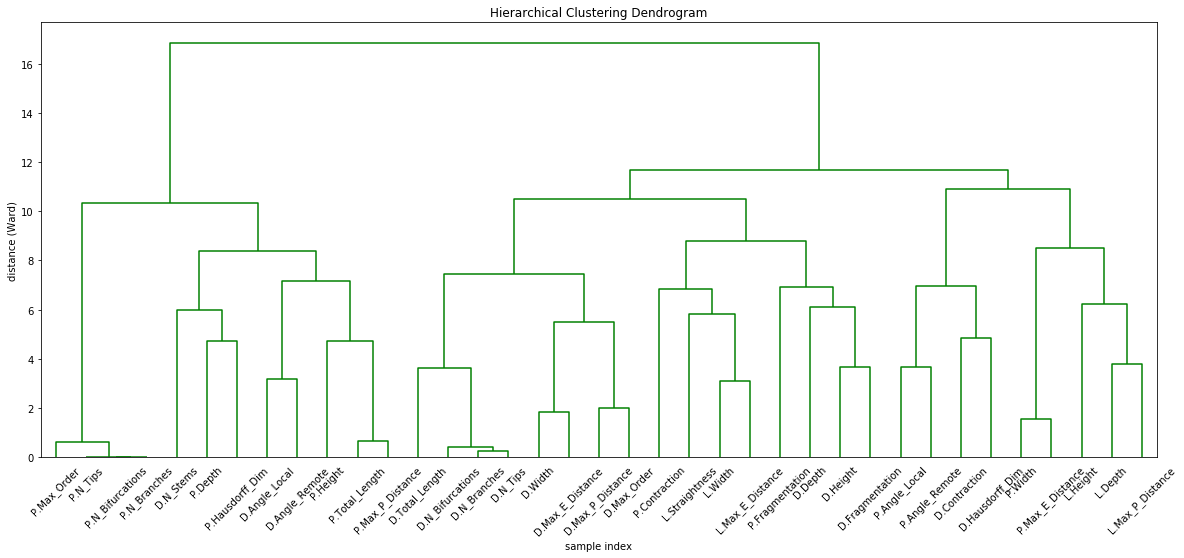

In [35]:
# Plot 1: Hierarchical clustering (by samples)

Z_sample = linkage(reduced_data_pca, 'ward')

thres = 10
fig, ax = plt.subplots(1,1,figsize=(20,8))
d = dendrogram(Z_sample, labels=df.index, leaf_rotation=45, leaf_font_size=10,
               color_threshold=thres, orientation="top",
              )
plt.axhline(y=thres, c='grey', lw=1, linestyle='dashed')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
my_color=celltypes.loc[d['ivl'], 'Type'].cat.codes-1
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    lbl.set_color(celltypes_pal[my_color[num]])
    
fig.savefig("Figure/Dendrogram_AllNeurons_Thalamus_LGN.pdf")

# Plot 2: Hierarchical clustering (by features)

Z_feature = linkage(df.transpose(), method = 'ward', metric='euclidean')

thres_feature = 25
fig, ax = plt.subplots(1,1,figsize=(20,8))
d = dendrogram(Z_feature, labels=df.columns, leaf_rotation=45, leaf_font_size=10,
               color_threshold=thres_feature, orientation="top",
              )
plt.axhline(y=thres_feature, c='grey', lw=1, linestyle='dashed')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

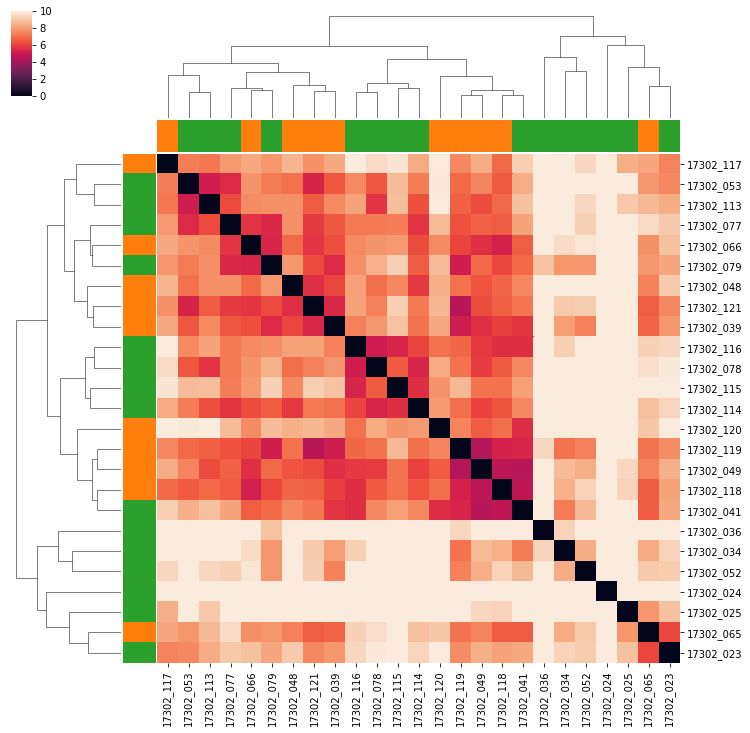

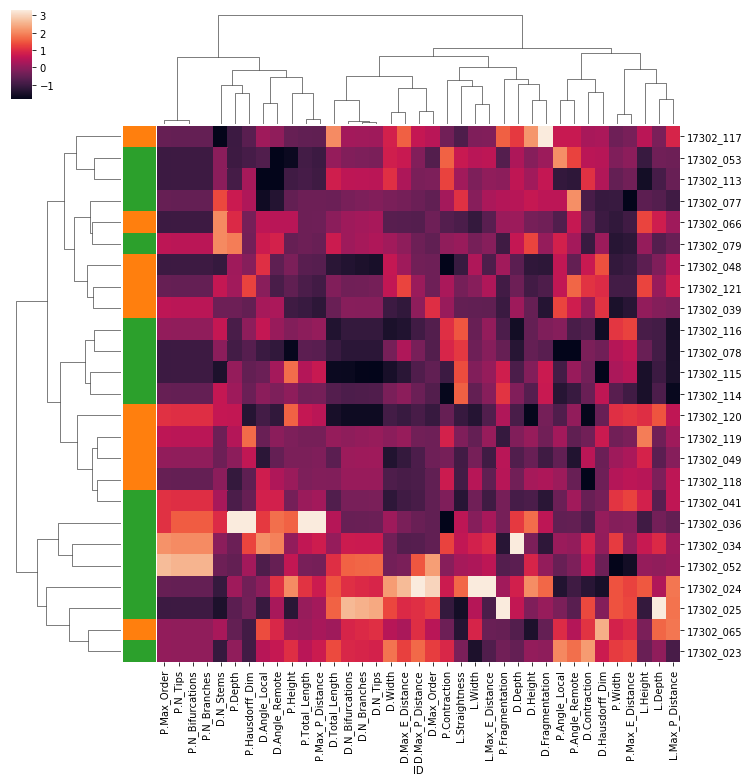

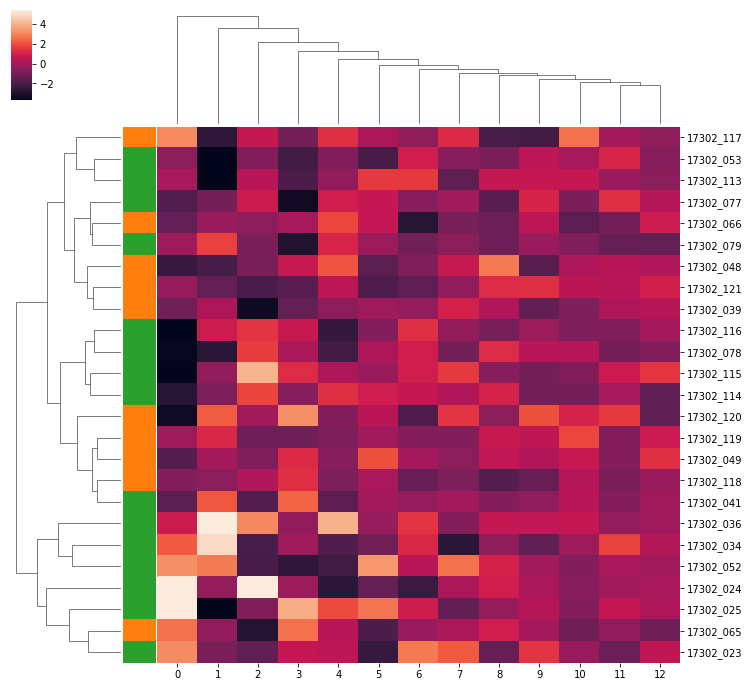

In [36]:
# Plot 1: Distance heatmap

dist = squareform(pdist(df))
dist = pd.DataFrame(dist, index=df.index, columns=df.index)

g = sns.clustermap(dist, vmax=thres, linecolor='white', 
                   row_colors=colors, col_colors=colors, 
                   row_linkage=Z_sample, col_linkage=Z_sample,
                   annot=False, figsize=(12,12))
g.savefig("Figure/Heatmap_Distance_AllNeurons_Thalamus_LGN.pdf")

# Plot 2: Feature heatmap

g = sns.clustermap(df, linewidths=0.0, linecolor='white', 
                   row_linkage=Z_sample, 
                   col_linkage=Z_feature, 
                   row_colors=colors,
                   vmax=np.percentile(df, 99),
                   vmin=np.percentile(df, 1),
                   annot=False, figsize=(12,12))
g.savefig("Figure/Heatmap_Features_AllNeurons_Thalamus_LGN.pdf")

# Plot 3: Reduced feature heatmap
tp_plot = pd.DataFrame(reduced_data_pca[:, :use_pcs], index=df.index)
g = sns.clustermap(tp_plot, linewidths=0.0, linecolor='white', 
                   row_linkage=Z_sample, 
                   row_colors=colors,
                   vmax=np.percentile(tp_plot, 99),
                   vmin=np.percentile(tp_plot, 1),                 
                   annot=False, figsize=(12,12))
g.savefig("Figure/Heatmap_PCA_AllNeurons_Thalamus_LGN.pdf")

Running Isomap...
Running tSNE...


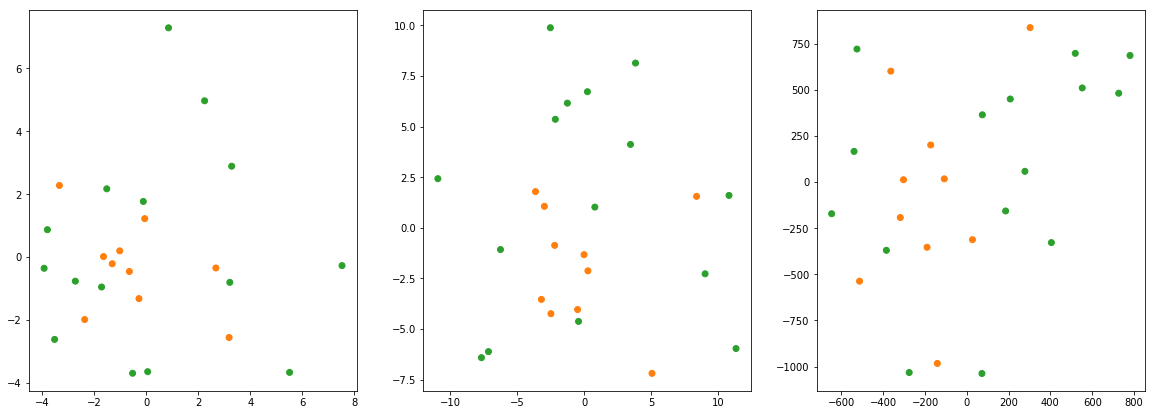

In [38]:
fig, ax = plt.subplots(1,3, figsize=(20, 7))

# PCA
ax[0].scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=colors)

# Isomap
print('Running Isomap...')
isomap = Isomap(n_neighbors=4)
X_iso = isomap.fit_transform(reduced_data_pca)
ax[1].scatter(X_iso[:, 0], X_iso[:, 1], c=colors)

# tSNE
print('Running tSNE...')
tsne = TSNE(n_components=2, perplexity=5, n_iter=10000, random_state=125,
            early_exaggeration=5, angle=0.25)
X_tsne = tsne.fit_transform(reduced_data_pca)
ax[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors)

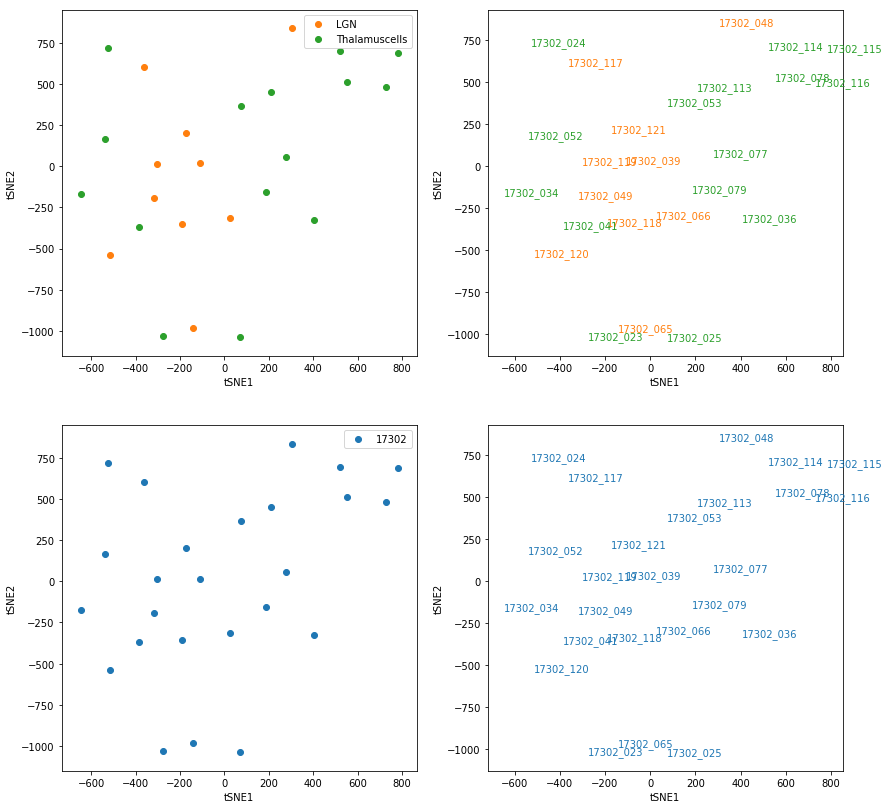

In [39]:
fig, ax = plt.subplots(2,2,figsize=(14,14))
ax = ax.reshape(-1,)
# tsne = TSNE(n_components=2, perplexity=7)
# X_tsne = tsne.fit_transform(reduced_data_pca)

X_plot = X_tsne

# By cell types
ax[0].scatter(X_plot[:, 0], X_plot[:, 1], c='w')
for ct in u_celltypes:
    lab = (celltypes['Type']==ct)
    ax[0].scatter(X_plot[lab, 0], X_plot[lab, 1], c=celltypes_lut[ct], label=ct)
ax[0].legend()
ax[0].set_xlabel('tSNE1')
ax[0].set_ylabel('tSNE2')

ax[1].scatter(X_plot[:, 0], X_plot[:, 1], c='w')
for ct in u_celltypes:
    lab = [i for i in range(len(celltypes)) if (celltypes['Type'][i]==ct)] 
    for i in lab:
        ax[1].text(X_plot[i, 0], X_plot[i, 1], df.index[i], {'color':celltypes_lut[ct]})
ax[1].set_xlabel('tSNE1')
ax[1].set_ylabel('tSNE2')

# By brain id's
ax[2].scatter(X_plot[:, 0], X_plot[:, 1], c='w')
for ct in u_brains:
    lab = (brains['Brain']==ct)
    ax[2].scatter(X_plot[lab, 0], X_plot[lab, 1], c=brains_lut[ct], label=ct)
ax[2].legend()
ax[2].set_xlabel('tSNE1')
ax[2].set_ylabel('tSNE2')

ax[3].scatter(X_plot[:, 0], X_plot[:, 1], c='w')
for ct in u_brains:
    lab = [i for i in range(len(brains)) if (brains['Brain'][i]==ct)] 
    for i in lab:
        ax[3].text(X_plot[i, 0], X_plot[i, 1], df.index[i], {'color':brains_lut[ct]})
ax[3].set_xlabel('tSNE1')
ax[3].set_ylabel('tSNE2')

fig.savefig("Figure/TSNE_Celltypes_AllNeurons_Thalamus_LGN.pdf")

In [46]:
tb.loc[["17302_065","17302_066"]].transpose()
# df.loc[["17302_065","17302_066"]].transpose()

,17302_065,17302_066
ID,,
Type,LGN,LGN
Unconnected(%),5.3431,6.39881
N_Single_Trees,8,11
Exist_duplicate_nodes,0,0
Brain,17302,17302
D.N_Nodes,4708,3902
D.N_Stems,8,13
D.N_Bifurcations,116,91
D.N_Branches,246,194


## Find clusters

Create KNN matrix...
Time elapsed:	 0.004625292000127956
Generate edges...
Time elapsed:	 0.06823967100353912
FastGreedy...
Time elapsed:	 1.46e-03
InfoMap...
Time elapsed:	 1.47e-01
Louvain...
Time elapsed:	 1.03e-03
Louvain...
Time elapsed:	 1.32e+00
LabelProp...
Time elapsed:	 1.34e-02
LeadingEigen...
Time elapsed:	 2.46e-02
Spinglass...
Time elapsed:	 1.76e+00
KMeans...
Time elapsed:	 9.40e-02
SpectralCluster...
Time elapsed:	 5.81e-02


/home/pengx/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


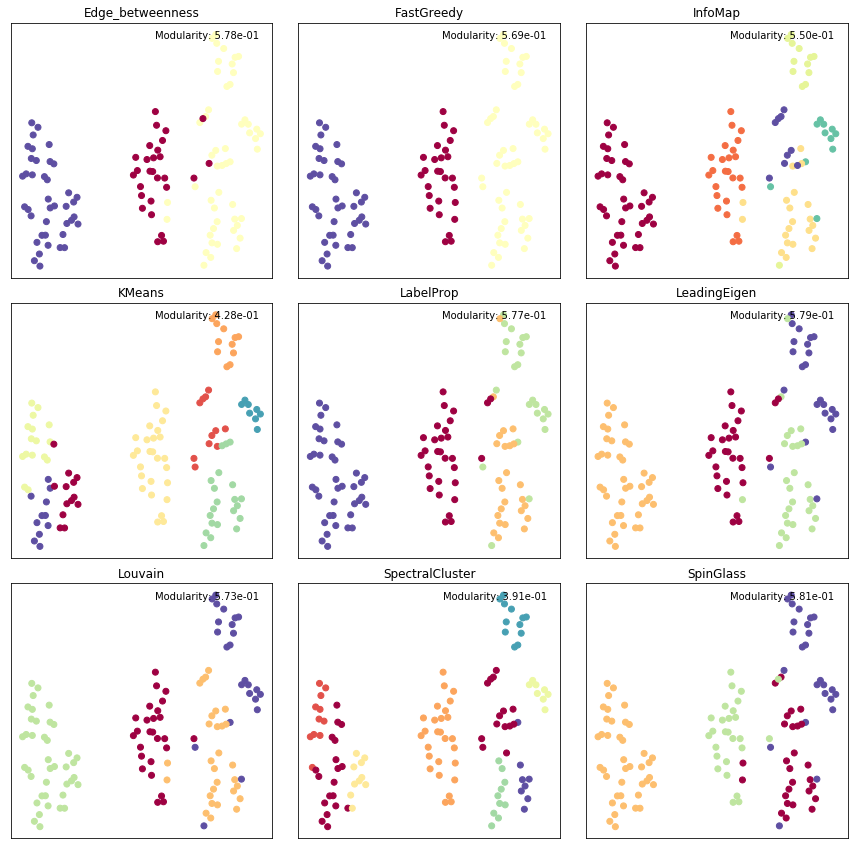

In [27]:
def df_filter(df):
    ind = []
    for i in range(df.shape[0]):
        if all(df.iloc[i,:] != ' -nan'):
            ind.append(i)
    df = df.astype('float64')
    return([df.iloc[ind,:], ind])

def feature_hist(df, ncol=4, len_single_plot = 5):
    n = df.shape[1]
    if((n % ncol)==0):
        nrow = n / ncol
    else:
        nrow = int(n / ncol) + 1
    fig, ax = plt.subplots(nrow, ncol, figsize=(len_single_plot*ncol, len_single_plot*nrow))
    ax = ax.reshape(-1,)
    for i in range(n):
        ax[i].hist(df.iloc[:,i], label = df.columns[i])
        ax[i].legend()
    return

def features_scatter(X, df, ncol=4, len_single_plot=3.5):
    n = df.shape[1]
    if((n % ncol)==0):
        nrow = n / ncol
    else:
        nrow = int(n / ncol) + 1
    fig, ax = plt.subplots(nrow, ncol, figsize=(len_single_plot*ncol, len_single_plot*nrow))
    ax = ax.reshape(-1,)
    for i in range(n):
        ax[i].scatter(X[:, 0], X[:, 1], c=df.iloc[:,i], cmap='coolwarm')
        ax[i].set_title(df.columns[i])
    return

def match1d(query, target):
    query = query.tolist()
    target = target.tolist()
    target = dict(zip(target, range(len(target))))
    if(set(query).issubset(set(target.keys()))):
        result = [target[i] for i in query]
        return(np.array(result))
    else:
        print("Query should be a subset of target!")
        return
    
def SNN(x, k=3):
    '''
    x: n x m matrix, n is #sample, m is #feature
    '''
    n, m = x.shape
    # Find a ranklist of neighbors for each sample
    timestamp = timer()
    print('Create KNN matrix...')
    knn = NearestNeighbors(n_neighbors=n)
    knn.fit(x)
    A = knn.kneighbors_graph(x, mode='distance')
    A = A.toarray()
    A_rank = A
    for i in range(n):
        A_rank[i,:] = np.argsort(A[i,:])
    A_rank = np.array(A_rank, dtype='int')
    A_knn = A_rank[:,:k]
    print("Time elapsed:\t", timer() - timestamp)

    # Create weighted edges between samples
    timestamp = timer()
    print('Generate edges...')
    edge = []
    for i in range(n):
        for j in range(i+1,n):
            shared = set(A_knn[i,:]).intersection(set(A_knn[j,:]))
            shared = np.array(list(shared))    
            if(len(shared) > 0): # When i and j have shared knn
                strength = k - (match1d(shared, A_knn[i,:]) + match1d(shared, A_knn[j, :]) + 2)/2
                strength = max(strength)
                if(strength>0):
                    edge = edge + [i+1, j+1, strength]            
    edge = np.array(edge).reshape(-1, 3)
    print("Time elapsed:\t", timer() - timestamp)
    return(edge)


'''
Create graph
'''

knn = 5
edge = SNN(reduced_data_pca, knn)

g = igraph.Graph()
# in order to add edges, we have to add all the vertices first
#iterate through edges and put all the vertices in a list
vertex = []
edge_list = [(int(edge[i,0])-1, int(edge[i,1])-1) for i in range(len(edge))]
for e in edge_list:
    vertex.extend(e)
g.add_vertices(list(set(vertex))) # add a list of unique vertices to the graph
g.add_edges(edge_list) # add the edges to the graph. 
g.es['weights'] = edge[:,2]


membership = dict()
modularity = dict()

'''
FastGreedy
'''
method = 'FastGreedy'
print(method+'...')
stamp = timer()
membership[method] = g.community_fastgreedy(weights='weights').as_clustering().membership
modularity[method] = g.modularity(membership[method])
print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

'''
InfoMap
'''
method = 'InfoMap'
print(method+'...')
stamp = timer()
membership[method] = g.community_infomap(edge_weights='weights', trials=15).membership
modularity[method] = g.modularity(membership[method])
print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

'''
Louvain
'''
method = 'Louvain'
print(method+'...')
stamp = timer()
membership[method] = g.community_multilevel(weights='weights').membership
modularity[method] = g.modularity(membership[method])
print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

'''
Edge_betweenness
'''
if len(edge)<10000:  # Slow method, only run for small datasets
    print(method+'...')
    stamp = timer()
    method = 'Edge_betweenness'
    membership[method] = g.community_edge_betweenness(weights='weights').as_clustering().membership
    modularity[method] = g.modularity(membership[method])
    print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

'''
Label propagation
'''
method = 'LabelProp'
print(method+'...')
stamp = timer()
modularity[method] = 0
for i in range(20):  # Like K-Means, random initialization yields different results. Therefore have to run multiple times (suggested 1000+) to achieve a consensus clustering
    tp_member = g.community_label_propagation(weights='weights').membership
    tp_modual = g.modularity(tp_member)
    if modularity[method] < tp_modual:
        membership[method] = tp_member
        modularity[method] = tp_modual
print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

'''
Leading eigenvector
'''
method = 'LeadingEigen'
print(method+'...')
stamp = timer()
membership[method] = g.community_leading_eigenvector(weights='weights').membership
modularity[method] = g.modularity(membership[method])
print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

'''
Spin glass
'''
method = 'Spinglass'
if len(edge) < 10000:
    print(method+'...')
    stamp = timer()
    method = 'SpinGlass'
    membership[method] = g.community_spinglass(weights='weights').membership
    modularity[method] = g.modularity(membership[method])
    print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))
   
'''
Kmeans
'''
method = 'KMeans'
print(method+'...')
stamp = timer()
membership[method] = KMeans(n_clusters=8, n_init=50).fit_predict(X_tsne)
modularity[method] = g.modularity(membership[method])
print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

'''
Spectral clustering
'''
method = 'SpectralCluster'
print(method+'...')
stamp = timer()
membership[method] = SpectralClustering(n_clusters=8, n_init=10, affinity='nearest_neighbors').fit_predict(X_tsne)
modularity[method] = g.modularity(membership[method])
print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

# '''
# DBSCAN
# '''
# method = 'DBSCAN'
# print(method+'...')
# stamp = timer()
# membership[method] = DBSCAN().fit_predict(X_tsne)
# if any(membership['DBSCAN']==-1):
#     modularity[method] = 'NA'
# else:
#     modularity[method] = g.modularity(membership[method])
# print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

# '''
# Birch
# '''
# method = 'Birch'
# print(method+'...')
# stamp = timer()
# membership[method] = Birch(n_clusters=8).fit_predict(X_tsne)
# modularity[method] = g.modularity(membership[method])
# print('Time elapsed:\t', '{:.2e}'.format(timer() - stamp))

methods = sorted(list(membership.keys()))

ncol = 3
nrow = ceil(len(methods) / ncol)
fig = plt.figure(figsize=(5*ncol, 5*nrow))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(len(membership)):
    ax = fig.add_subplot(nrow, ncol, i+1)
    ax.scatter(X_tsne[:,0], X_tsne[:,1], c=membership[methods[i]], cmap='Spectral')
    ax.set_title(methods[i])
    txt = "Modularity: " + ('NA' if modularity[methods[i]]=='NA' else '{:.2e}'.format(modularity[methods[i]]))
    ax.text(0.75, 0.95, txt,
            ha='center',
            va='center',
            transform = ax.transAxes
           )
    plt.tick_params(axis='both', 
                    left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
plt.savefig("Figure/TSNE_Clustering_AllNeurons.pdf")

In [31]:
membership.keys()

dict_keys(['FastGreedy', 'InfoMap', 'Louvain', 'Edge_betweenness', 'LabelProp', 'LeadingEigen', 'SpinGlass', 'KMeans', 'SpectralCluster'])

In [34]:
cluster = pd.DataFrame(index=df.index, columns=membership.keys())
cluster.head()
for method in cluster.columns.tolist():
    cluster[method] = membership[method]
 
cluster.to_excel("Table/F_cluster.xlsx")
cluster.head()

,FastGreedy,InfoMap,Louvain,Edge_betweenness,LabelProp,LeadingEigen,SpinGlass,KMeans,SpectralCluster
17302_087,0,1,0,0,0,0,2,3,2
17302_089,0,1,0,0,0,0,2,3,2
17302_092,0,1,0,0,0,0,2,3,2
17302_097,0,1,0,0,0,0,2,3,2
17302_082,1,5,1,1,1,2,0,1,0


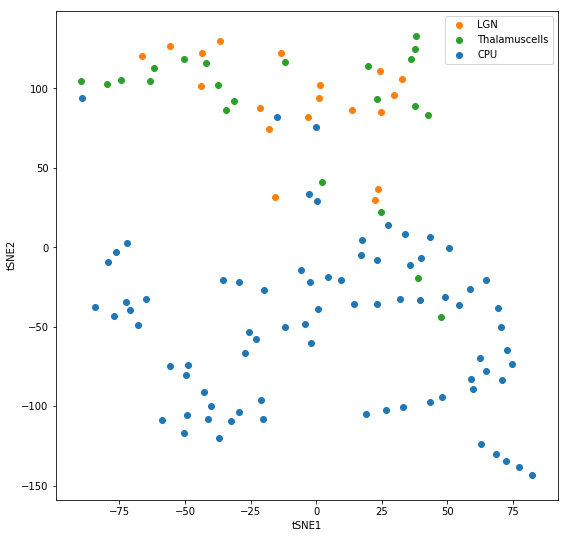

In [17]:
'''
What about only using dendrite features?
'''
def dendrite_clustering(df):
    colors = celltypes_col

    df = sub_df(df, "D")
    # Create a regular PCA model 
    pca = PCA(n_components=df.shape[1])
    # Fit and transform the data to the model
    reduced_data_pca = pca.fit_transform(df)

    tp = np.append(np.array([0]), np.cumsum(pca.explained_variance_ratio_)*100)
    for i in range(len(tp)):
        if tp[i]>95:
            use_pcs = i
            break
#     plt.plot(range(0, len(tp)), tp)
#     plt.xlabel('# Principle Components')
#     plt.ylabel('% Variance Explained')
#     plt.axvline(use_pcs, c='r', lw=1, ls='dashed')
#     plt.axhline(tp[use_pcs], c='r', lw=1, ls='dashed')
#     plt.axvline(5, c='grey', lw=1, ls='dashed')
#     plt.axhline(tp[5], c='grey', lw=1, ls='dashed')
#     plt.ylim(tp[1], 102)
    # Fit and transform the data to the model
    reduced_data_pca = reduced_data_pca[:,:use_pcs]
    
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    tsne = TSNE(n_components=2, perplexity=5, n_iter=10000, random_state=125,
            early_exaggeration=5, angle=0.25)
    X_tsne = tsne.fit_transform(reduced_data_pca)

    X_plot = X_tsne

    # By cell types
    ax.scatter(X_plot[:, 0], X_plot[:, 1], c='w')
    for ct in u_celltypes:
        lab = (celltypes['Type']==ct)
        ax.scatter(X_plot[lab, 0], X_plot[lab, 1], c=celltypes_lut[ct], label=ct)
    ax.legend()
    ax.set_xlabel('tSNE1')
    ax.set_ylabel('tSNE2')
    
dendrite_clustering(df)